<a href="https://colab.research.google.com/github/ehadsaloF/Electricity-Demand-Forecasting/blob/main/Electricity_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error



import warnings
warnings.filterwarnings("ignore")

This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. 

In [ ]:
df = pd.read_csv('/content/energy2.csv', index_col=['time'])
df.index = pd.to_datetime(df.index, errors='coerce', utc=True)

In [ ]:
df.head()

total load forecast  total load actual
time                                                             
2014-12-31 23:00:00+00:00                26118            25385.0
2015-01-01 00:00:00+00:00                24934            24382.0
2015-01-01 01:00:00+00:00                23515            22734.0
2015-01-01 02:00:00+00:00                22642            21286.0
2015-01-01 03:00:00+00:00                21785            20264.0

In [ ]:
df.shape

(35064, 2)

##Data Cleaning

In [ ]:
# check for datatype of features
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total load forecast  35064 non-null  int64  
 1   total load actual    35028 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 821.8 KB


There are 36 missing values for the total load actual column, this will be filled using KNN imputation

In [ ]:
# Make sure the data is sorted in ascending order by date
df = df.sort_index()

# Find the missing values in the data
missing_mask = df['total load actual'].isnull()

# Convert the DataFrame to a NumPy array
data_array = df.values

# Initialize the KNN imputer with k=5
imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
imputed_data_array = imputer.fit_transform(data_array)

# Convert the imputed array back to a DataFrame
imputed_data = pd.DataFrame((imputed_data_array), columns=df.columns, index=df.index)

imputed_data['total load actual'] = imputed_data['total load actual'].apply(lambda x: math.ceil(x))

In [ ]:
imputed_data[missing_mask]

total load forecast  total load actual
time                                                             
2015-01-05 11:00:00+00:00              23209.0              23259
2015-01-05 12:00:00+00:00              23725.0              23805
2015-01-05 13:00:00+00:00              23614.0              23583
2015-01-05 14:00:00+00:00              22381.0              22452
2015-01-05 15:00:00+00:00              21371.0              21029
2015-01-05 16:00:00+00:00              20760.0              20736
2015-01-28 12:00:00+00:00              36239.0              36568
2015-02-01 06:00:00+00:00              24379.0              24354
2015-02-01 07:00:00+00:00              27389.0              27682
2015-02-01 08:00:00+00:00              30619.0              30595
2015-02-01 11:00:00+00:00              31357.0              31257
2015-02-01 12:00:00+00:00              31338.0              31259
2015-02-01 13:00:00+00:00              30874.0              30611
2015-02-01 14:00:00+00:00              30124.0              29685
2015-02-01 15:00:00+00:00              29714.0              30068
2015-02-01 16:00:00+00:00              29801.0              29614
2015-02-01 17:00:00+00:00              32257.0              32238
2015-02-01 18:00:00+00:00              33183.0              33172
2015-04-05 01:00:00+00:00              20016.0              19947
2015-04-16 07:00:00+00:00              31001.0              30622
2015-04-20 06:00:00+00:00              29287.0              29294
2015-04-23 19:00:00+00:00              31421.0              31177
2015-05-02 08:00:00+00:00              39644.0              39129
2015-05-29 01:00:00+00:00              23132.0              23519
2015-10-02 06:00:00+00:00              36798.0              36854
2015-10-02 09:00:00+00:00              38921.0              38733
2015-12-02 08:00:00+00:00              37413.0              37386
2016-04-25 03:00:00+00:00              21471.0              21428
2016-04-25 05:00:00+00:00              27635.0              27324
2016-05-10 21:00:00+00:00              26641.0              26895
2016-07-09 20:00:00+00:00              34985.0              34908
2016-09-28 07:00:00+00:00              31072.0              31043
2017-11-14 11:00:00+00:00              33805.0              33422
2017-11-14 18:00:00+00:00              35592.0              35196
2018-06-11 16:00:00+00:00              34752.0              34570
2018-07-11 07:00:00+00:00              33938.0              33950

In [ ]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total load forecast  35064 non-null  float64
 1   total load actual    35064 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 821.8 KB


##Descriptive Statistics

In [ ]:
#descriptive statistics
imputed_data.describe()

total load forecast  total load actual
count         35064.000000       35064.000000
mean          28712.129962       28697.917380
std            4594.100854        4575.984217
min           18105.000000       18041.000000
25%           24793.750000       24807.000000
50%           28906.000000       28902.500000
75%           32263.250000       32193.000000
max           41390.000000       41015.000000

## Univariate Electricity Demand Forecast

### Decomposition Technique
Time series data is usually composed of four components, a trend component which indicates an increase or decrease in the data over a long period of time, a cyclical component which causes the data to rise and fall over a period of time that is longer than a season, a seasonal component that indicates the data fluctuates regularly around the trend line and a noise component that represents the part of the data that is not accounted for by the other components. 

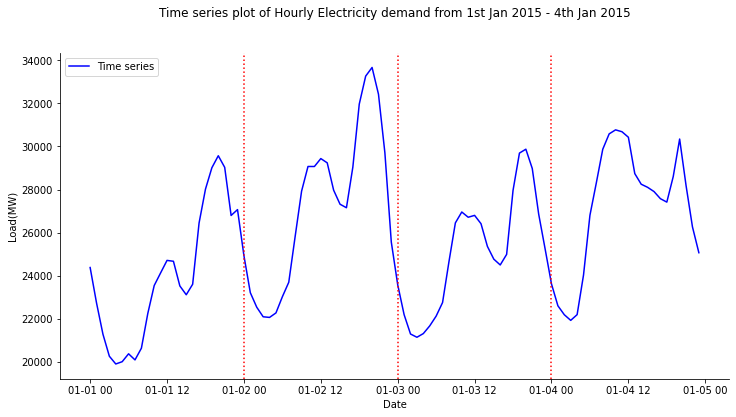

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

#resampling data 
daily_dem = imputed_data.resample('H').mean()

# define the start and end dates for the plot
start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-01-04 23:00:00+00:00'

# subset the data to include only the desired date range
subset_data = daily_dem.loc[start_date:end_date]

# plot the time series data
ax.plot(subset_data.index, subset_data['total load actual'], color='blue', label='Time series')

# insert lines at certain dates
line_dates = pd.to_datetime(['2015-01-02 00','2015-01-03 00', '2015-01-04 00'])
for date in line_dates:
    ax.axvline(x=date, color='red', linestyle=':')

# customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Load(MW)')
ax.set_title('Time series plot of Hourly Electricity demand from 1st Jan 2015 - 4th Jan 2015\n\n')
ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# show the plot
plt.show()


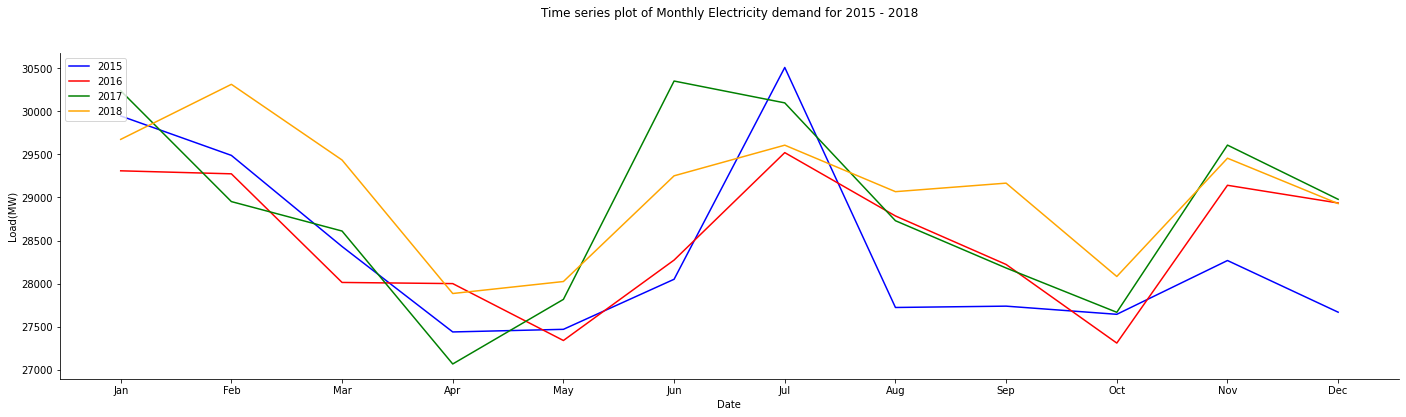

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(24, 6))

#resampling data by month
monthly_dem = imputed_data.resample('M').mean()

# Extract year data and the year from the index
dem_2015 = monthly_dem.loc['2015-01': '2015-12']
dem_2015.index = dem_2015.index.strftime('%m')

dem_2016 = monthly_dem.loc['2016-01': '2016-12']
dem_2016.index = dem_2016.index.strftime('%m')

dem_2017 = monthly_dem.loc['2017-01': '2017-12']
dem_2017.index = dem_2017.index.strftime('%m')

dem_2018 = monthly_dem.loc['2018-01': '2018-12']
dem_2018.index = dem_2018.index.strftime('%m')

# plot the time series data
ax.plot(dem_2015.index, dem_2015['total load actual'], color='blue', label='2015')

ax.plot(dem_2016.index, dem_2016['total load actual'], color='red', label='2016')

ax.plot(dem_2017.index, dem_2017['total load actual'], color='green', label='2017')

ax.plot(dem_2018.index, dem_2018['total load actual'], color='orange', label='2018')



# customize the plot

# Set the x-axis tick labels
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_xlabel('Date')
ax.set_ylabel('Load(MW)')
ax.set_title('Time series plot of Monthly Electricity demand for 2015 - 2018\n\n')
ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# show the plot
plt.show()


The Graph above is the time series plot of Hourly electricity demand from 1st Jan 2015 - 4th Jan 2015
<p> The plot shows that the data is seasonal, the three vertical lines show a pattern in the data that repeats every 24 Hours, this indicates that the data has 24 seasons. 

 <p>An additive model is appropriate for this data because the seasonal variations are relatively constant over time. 
 <p> In additive decomposition, the time series data, Yt, is a sum of the decomposed components, i.e.,  


> <p> Y(t) = T(t) + S(t) + E(t)












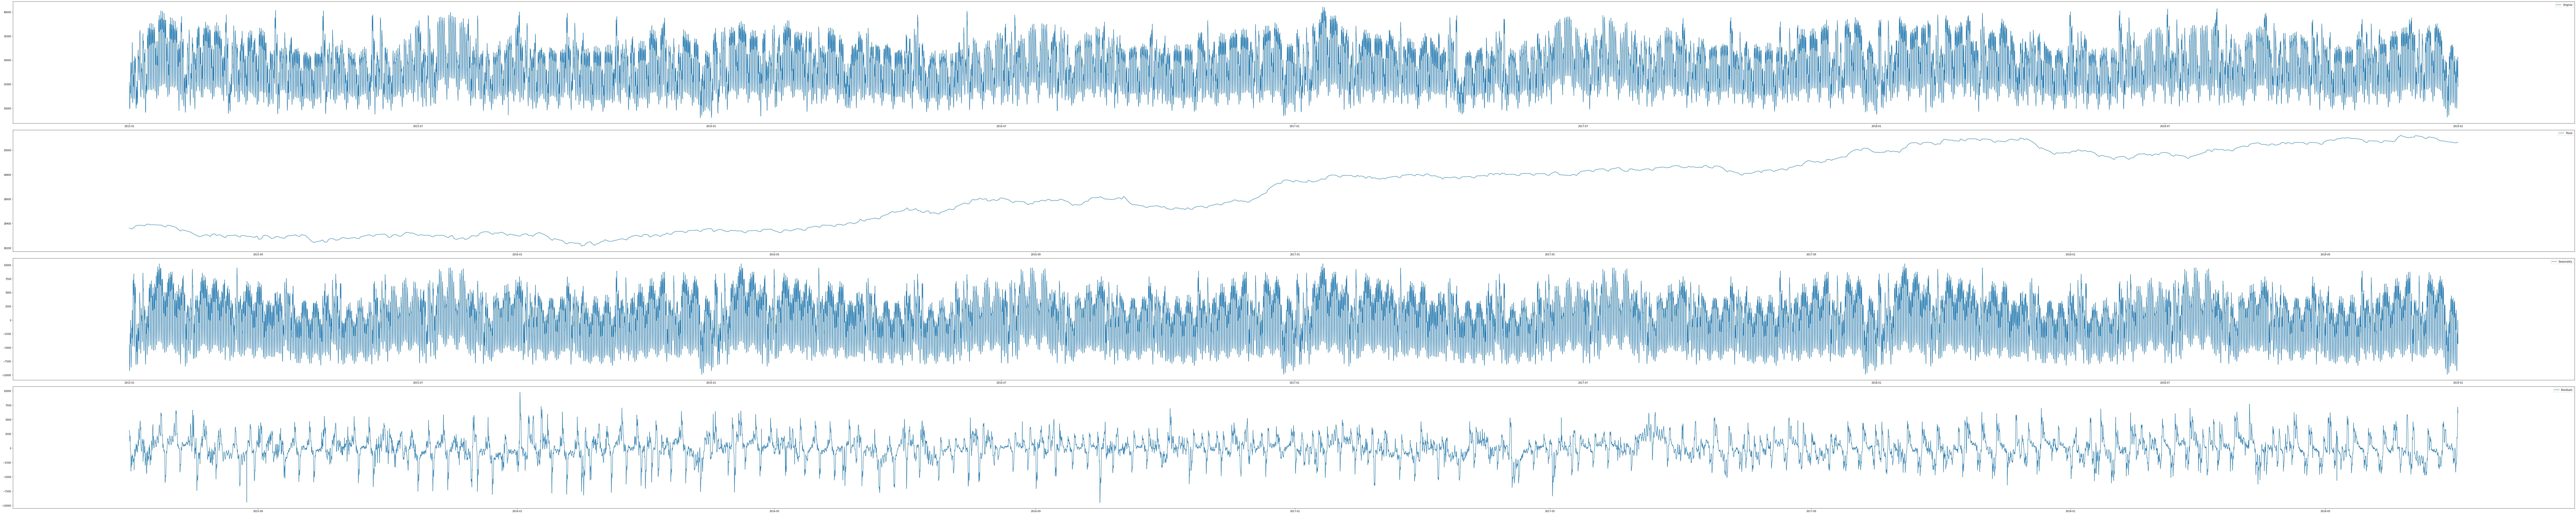

In [ ]:
# perform additive decomposition

decomposition = seasonal_decompose(imputed_data[['total load actual']], model='additive',period=24*365)

# plot the decomposition results


plt.figure(figsize=(150,30))
plt.subplot(411)
plt.plot(imputed_data[['total load actual']], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# ax.legend(loc='best')
# plt.show()



After decomposing the data, we will then train various model on the deseasonalized data

###Linear Regression

In [120]:
# Get the deseasonalized data
deseasonalized = imputed_data['total load actual'] - decomposition.seasonal

deseasonalized

time
2014-12-31 23:00:00+00:00    29858.487807
2015-01-01 00:00:00+00:00    30553.956472
2015-01-01 01:00:00+00:00    30329.777058
2015-01-01 02:00:00+00:00    29888.601430
2015-01-01 03:00:00+00:00    29409.106358
                                 ...     
2018-12-31 18:00:00+00:00    30690.254360
2018-12-31 19:00:00+00:00    29981.017849
2018-12-31 20:00:00+00:00    29260.080311
2018-12-31 21:00:00+00:00    28696.461209
2018-12-31 22:00:00+00:00    28757.511228
Length: 35064, dtype: float64

In [121]:
# Split the data into training and test sets
train = deseasonalized[:'2018-10-31 00:00:00+00:00']
test = deseasonalized['2018-10-31 01:00:00+00:00':]

# check the sizes of the training and testing sets
print(f'Training set size: {len(train)}')
print(f'Testing set size: {len(test)}')


Training set size: 33578
Testing set size: 1486


In [122]:
# Train a linear regression model on the training data
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = np.array(train.values)


model = LinearRegression().fit(X_train, y_train)


In [123]:
# Forecast using the linear regression model on the test data
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_pred = model.predict(X_test)


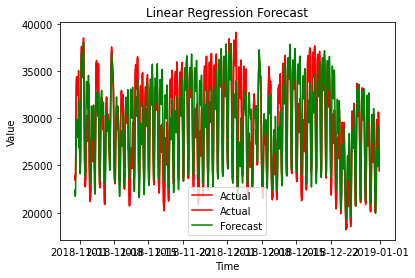

In [124]:
# Add the seasonal component back to the forecasted values
y_forecast = y_pred + decomposition.seasonal['2018-10-31 01:00:00+00:00':]
# + abs(decomposition.seasonal[-24*40:])
# Plot the actual and forecasted values
fig, ax = plt.subplots()
ax.plot(imputed_data['2018-10-31 01:00:00+00:00':].index, imputed_data['2018-10-31 01:00:00+00:00':].values, color = 'red', label='Actual')
ax.plot(imputed_data['2018-10-31 01:00:00+00:00':].index, y_forecast, color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Linear Regression Forecast')
ax.legend()
plt.show()

#### Model Evaluation

In [127]:
#function that outputs the MSE, RMSE and MAE 
def perf_m (r,d):
  # Calculate MSE
  mse = mean_squared_error(r, d)
  print("MSE:", mse)

  # Calculate RMSE
  rmse = np.sqrt(mse)
  print("RMSE:", rmse)

  # Calculate MAE
  mae = mean_absolute_error(r, d)
  print("MAE:", mae)

In [129]:
perf_m(imputed_data['2018-10-31 01:00:00+00:00':]['total load actual'].values, y_forecast)

MSE: 7648262.229800748
RMSE: 2765.549173274767
MAE: 2090.6162377576693


### LSTM

In [ ]:
# sort DataFrame by datetime index in ascending order

train = train.sort_index(ascending=True)
test = train.sort_index(ascending=True)
train.head()

total load forecast  total load actual
time                                                             
2014-12-31 23:00:00+00:00              26118.0              25385
2015-01-01 00:00:00+00:00              24934.0              24382
2015-01-01 01:00:00+00:00              23515.0              22734
2015-01-01 02:00:00+00:00              22642.0              21286
2015-01-01 03:00:00+00:00              21785.0              20264